In [76]:
from pprint import pprint
from datetime import datetime
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view
from utils import *
from utils import markdown
from scipy import stats
    
def data_iterator():
    data = load_nested_dict('data/Processed', ignore=IGNORE_NO_EYETRACKING)
    for i, (participant, _data1) in enumerate(data.items()):
        for j, (experiment, _data2) in enumerate(_data1.items()):
            yield (i, participant), (j, experiment[3:]), _data2

def compute_failure_proportion_intervals():
    data = load_nested_dict('data/Processed')
    def _gen():
        for (_, participant), (_, experiment), _data2 in data_iterator():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            for task, _data3 in sorted(_data2['tasks'].items()):
                failure_intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
                failure_intervals = merge_intervals(failure_intervals) - start_time # merge them to get failures for a single task
                if len(failure_intervals) > 0:
                    yield np.full(failure_intervals.shape[0], participant), np.full(failure_intervals.shape[0], experiment), np.full(failure_intervals.shape[0], task), failure_intervals[:,0], failure_intervals[:,1]
    data = [np.concatenate(x, axis=0) for x in zip(*_gen())]
    data = dict(zip(['participant', 'experiment', 'task', 't1', 't2'], data))
    return pd.DataFrame(data)

def compute_warning_intervals():
    def _compute_warning_intervals(data, task, start_time, finish_time):
        data = data['warnings'][task]
        return compute_time_intervals(data['value'].astype(int), data['timestamp'], start_time, finish_time).intervals
    def _gen():
        for (_, participant), (_, experiment), _data2 in data_iterator():
            if 'icua' in experiment:
                start_time, finish_time =  _data2['start_time'], _data2['finish_time']
                for task, _data3 in sorted(_data2['tasks'].items()):
                    wi = _compute_warning_intervals(_data2, task, start_time, finish_time) - start_time
                    if len(wi) > 0:
                        yield np.full(wi.shape[0], participant), np.full(wi.shape[0], experiment), np.full(wi.shape[0], task), wi[:,0], wi[:,1]
    data = [np.concatenate(x, axis=0) for x in zip(*_gen())]
    data = dict(zip(['participant', 'experiment', 'task', 't1', 't2'], data))
    return pd.DataFrame(data)
            
     
def compute_eyetracking_intervals():
    def _compute_eyetracking_intervals(data, task, start_time, finish_time, gaze_only=True):
        data = data['eye_tracking']
        window_properties = ALL_WINDOW_PROPERTIES[task]
        # compute gaze intervals
        intaskbox = in_box(data['x'].to_numpy(), data['y'].to_numpy(), window_properties['position'], window_properties['size'])
        if gaze_only: # USE THIS IF WE ONLY WANT GAZE
            gaze = data['gaze'].to_numpy().astype(bool)
            intaskbox = np.logical_and(intaskbox, gaze).astype(int)
        return compute_time_intervals(intaskbox, data['timestamp'].to_numpy(), start_time, finish_time, pad='next').intervals
    
    def _gen():
        for (_, participant), (_, experiment), _data2 in data_iterator():
            print(participant, experiment)
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            for task, _data3 in sorted(_data2['tasks'].items()):
                wi = _compute_eyetracking_intervals(_data2, task, start_time, finish_time) - start_time
                yield np.full(wi.shape[0], participant), np.full(wi.shape[0], experiment), np.full(wi.shape[0], task), wi[:,0], wi[:,1]
    
    data = [np.concatenate(x, axis=0) for x in zip(*_gen())]
    data = dict(zip(['participant', 'experiment', 'task', 't1', 't2'], data))
    return pd.DataFrame(data)
            
def compute_interval_complement_nonoverlapping(interval, intervals):
    A,B = interval
    sorted_indices = np.argsort(intervals[:, 0])
    sorted_intervals = intervals[sorted_indices]
    sorted_intervals = sorted_intervals[sorted_intervals[:, 1] <= B]
    
    complement = []
    # Keep track of the current endpoint as we traverse the sorted intervals
    current_end = A
    for x, y in sorted_intervals:
        # If the current interval does not extend to the current endpoint
        if x > current_end:
            complement.append((current_end, x))
        # Update the current endpoint if the interval endpoint is greater than the current endpoint
        current_end = max(current_end, y)
    # If there is a remaining portion of (A, B) after the last interval
    if current_end < B:
        complement.append((current_end, B))
    return np.array(complement)

def intervals_overlapping_intervals(A, B):
    result = np.zeros((len(A), len(B)), dtype=bool)
    # Check for each interval in A if it overlaps with any interval in B
    for i in range(len(A)):
        result[i] = (A[i, 0] <= B[:, 1]) & (A[i, 1] >= B[:, 0])
    return result
        
dfp = compute_failure_proportion_intervals()
dfw = compute_warning_intervals()
dfe = compute_eyetracking_intervals()


P01 icuA
P01 icuB
P01 icuaA
P01 icuaB
P02 icuA
P02 icuB
P02 icuaA
P02 icuaB
P04 icuA
P04 icuB
P04 icuaA
P04 icuaB
P05 icuA
P05 icuB
P05 icuaA
P05 icuaB
P06 icuA
P06 icuB
P06 icuaA
P06 icuaB
P07 icuA
P07 icuB
P07 icuaA
P07 icuaB
P08 icuA
P08 icuB
P08 icuaA
P08 icuaB
P09 icuA
P09 icuB
P09 icuaA
P09 icuaB
P10 icuA
P10 icuB
P10 icuaA
P10 icuaB
P16 icuA
P16 icuB
P16 icuaA
P16 icuaB
P17 icuA
P17 icuB
P17 icuaA
P17 icuaB
P18 icuA
P18 icuB
P18 icuaA
P18 icuaB
P23 icuA
P23 icuB
P23 icuaA
P23 icuaB
P24 icuA
P24 icuB
P24 icuaA
P24 icuaB
P25 icuA
P25 icuB
P25 icuaA
P25 icuaB


In [70]:
GRACE_PERIOD = 2

def highlighted_intervals(fp, fw):
    # sanity checker - check whether a particular failure interval was ACTUALLY highlighted by an agent. This should match "should_highlight" for any icua experiment.
    def _gen():
        for _, row in fp.iterrows():
            _fw = fw[fw['task'] == row['task']]
            _fw = (_fw['t1'] > row['t1']) & (_fw['t1'] < row['t2'])
            yield np.any(_fw)
    sh = np.array(list(_gen()))
    return fp[sh]

def should_highlight(fp, fe):
    # find those failure intervals that would have been highlighted by an agent
    fp = fp[(fp['t2'] - fp['t1']) > GRACE_PERIOD]  # any under grace period will not be highlighted..? maybe?
    def _gen():
        # any over grace period will be highlighted if the participant doesnt look at it for > GRACE_PERIOD
        for _, row in fp.iterrows():
            _fe = fe[fe['task'] == row['task']] # efficiency (not required)
            interval, intervals = (row['t1'], row['t2']), _fe[['t1', 't2']].to_numpy()
            comp = compute_interval_complement_nonoverlapping(interval, intervals)
            dif = comp[:,1] - comp[:,0]
            comp = comp[dif > GRACE_PERIOD]
            if  len(comp) > 0:
                yield row # this is the row
            #if len(comp) > 0:
            #yield np.full(comp.shape[0], row['participant']), np.full(comp.shape[0], row['experiment']), np.full(comp.shape[0], row['task']), *comp.T    
    #columns=['participant', 'experiment', 'task', 't1', 't2']
    #return pd.DataFrame(dict(zip(columns,[np.concatenate(x, axis=0) for x in zip(*_gen())])))
    return pd.DataFrame(_gen())

def get_highlighted_failure_interval_mean_durations():
    def _gen():
        for (_, participant), (_, experiment), _ in data_iterator():
            fp = dfp[(dfp['participant'] == participant) & (dfp['experiment'] == experiment)] 
            fe = dfe[(dfe['participant'] == participant) & (dfe['experiment'] == experiment)] 
            fw = dfw[(dfw['participant'] == participant) & (dfw['experiment'] == experiment)] 

            # failure intervals that would have been highlighted (ignoring simultaneous highlight condition)
            sh = should_highlight(fp, fe)  
            if len(sh) > 0:
                sh['score'] = (sh['t2'] - sh['t1']).copy()
                yield sh
                
            #if len(sh) > 0:
                #ov = intervals_overlapping_intervals(fp[['t1', 't2']].to_numpy(), sh[['t1', 't2']].to_numpy())
                #df = fp[ov.any(axis=1)].copy()
                #df['score'] = (df['t2'] - df['t1']).copy()
                #yield df
                #if len(fw) > 0:
                #    _ov = intervals_overlapping_intervals(fp[['t1', 't2']].to_numpy(), fw[['t1', 't2']].to_numpy())
                #    print(df)
                #    print(fp[_ov.any(axis=1)])
                #    print(fw)
                #    print()
            
    return pd.concat(list(_gen())).reset_index(drop=True)
df = get_highlighted_failure_interval_mean_durations()

A: 1478.000 & 0.902 \\ \hline 
B: 13980.000 & 0.219 \\ \hline 


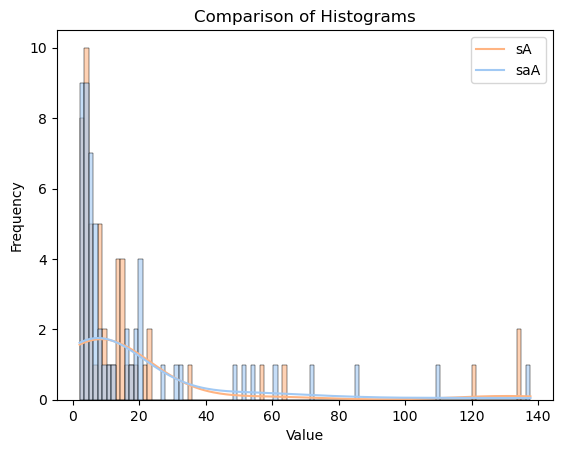

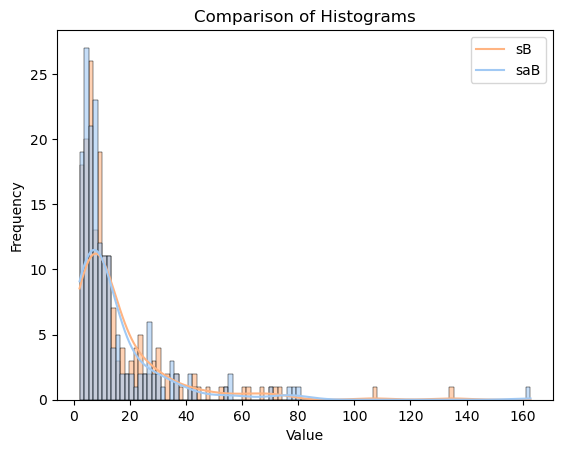

In [71]:


sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
print(f"A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
print(f"B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

def plot_hist(data):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    sns.histplot(data=_df, kde=True, alpha=0.6, palette='pastel', bins=100)
    plt.legend(data.keys())
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Comparison of Histograms')
    plt.show()
    
plot_hist({'sA': sA['score'], 'saA': saA['score']})
plot_hist({'sB': sB['score'], 'saB': saB['score']})



In [ ]:
#_fe = fe[fe['task'] == row['task']] # efficiency (not required)
#_fe1 = (_fe['t1'] > row['t1']) & (_fe['t1'] < row['t2']) # gaze started during failure
#_fe2 = (_fe['t2'] > row['t1']) & (_fe['t2'] < row['t2']) # gaze ended during failure
#_fe3 = (_fe['t1'] < row['t1']) & (_fe['t2'] > row['t2']) # gaze across failure
#_fe = _fe[_fe1 | _fe2 | _fe3] # check for gaze within the interval
# also check time from start/end of failure interval
#t1 = np.array([*_fe['t1'].to_numpy(), row['t2']])
#t2 = np.array([row['t1'], *_fe['t2'].to_numpy()])

#print(t1, t2)

#yield np.any((t1 - t2) > GRACE_PERIOD) # this means a highlight would have been shown!



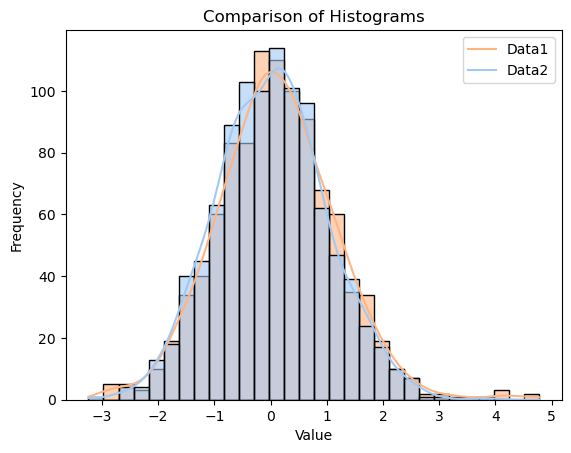

MannwhitneyuResult(statistic=478242.0, pvalue=0.09200641377610866)


In [199]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generating two sets of random data for comparison
np.random.seed(42)
data1 = np.random.normal(loc=0, scale=1, size=1000)
a = 0.99
data2 = np.concatenate([np.random.normal(loc=0, scale=1, size=int(1000*a)), np.random.normal(loc=3, scale=1.5, size=int(1000*(1-a)))])



# Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
df = pd.DataFrame({'Data1': data1, 'Data2': data2})

# Plot the histograms using Seaborn
sns.histplot(data=df, kde=True, bins=30, alpha=0.6, palette='pastel')

# Add a legend to distinguish the two datasets
plt.legend(['Data1', 'Data2'])

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Comparison of Histograms')

# Show the plot
plt.show()

print(stats.mannwhitneyu(data1, data2))


In [206]:
import numpy as np

def intervals_overlapping_intervals(A, B):
    result = np.zeros((len(A), len(B)), dtype=bool)
    # Check for each interval in A if it overlaps with any interval in B
    for i in range(len(A)):
        result[i] = (A[i, 0] <= B[:, 1]) & (A[i, 1] >= B[:, 0])
    return result

# Example usage
if __name__ == "__main__":
    A = [(1, 4)]
    B = [(-1,0),(0,2),(2,3),(3,5),(5,6)]

    result = intervals_overlapping_intervals(A, B)
    print("Intervals overlapping with B:")
    print(result)

    

Intervals overlapping with B:
[[False  True  True  True False]]


P01 & 0.105 & 0.109 \\ \hline 


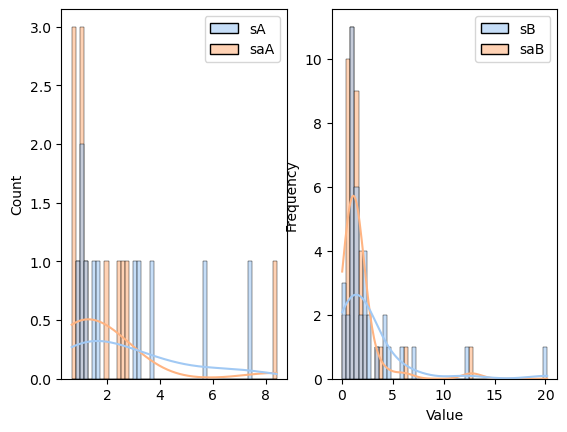

P02 & 0.804 & 0.789 \\ \hline 


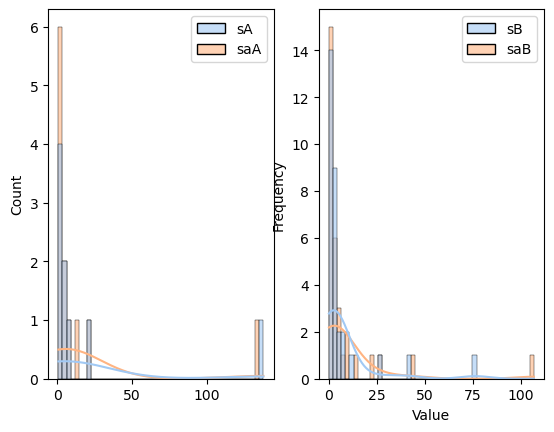

P04 & 0.482 & 0.455 \\ \hline 


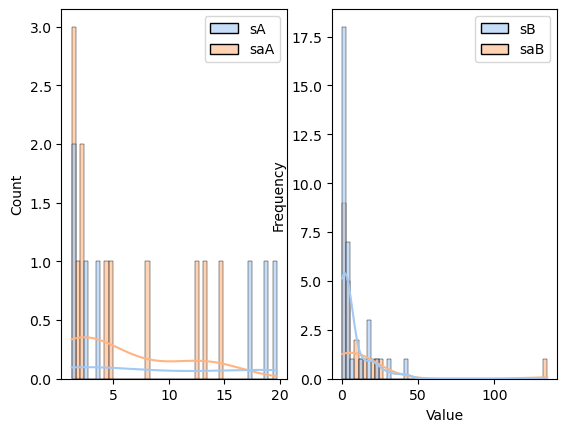

P05 & 0.865 & 0.747 \\ \hline 


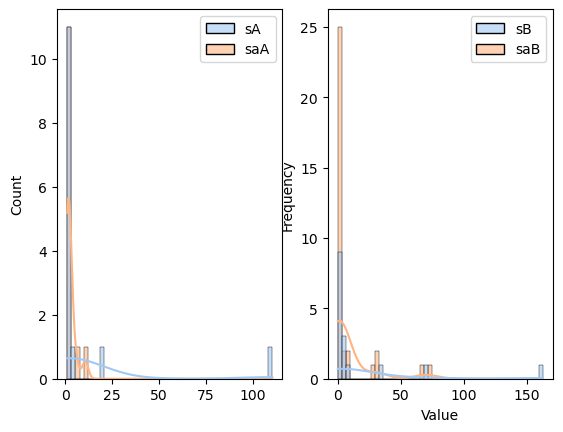

P06 & 0.074 & 0.887 \\ \hline 


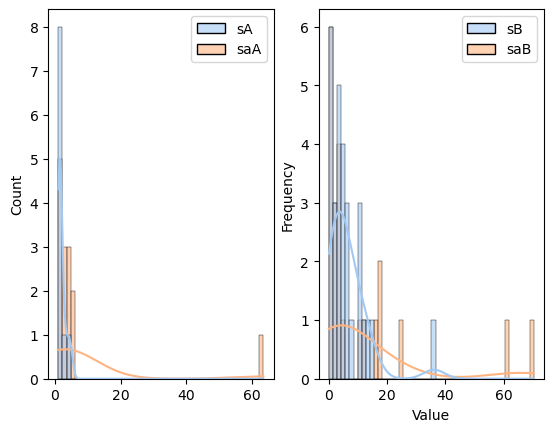

P07 & 0.465 & 0.099 \\ \hline 


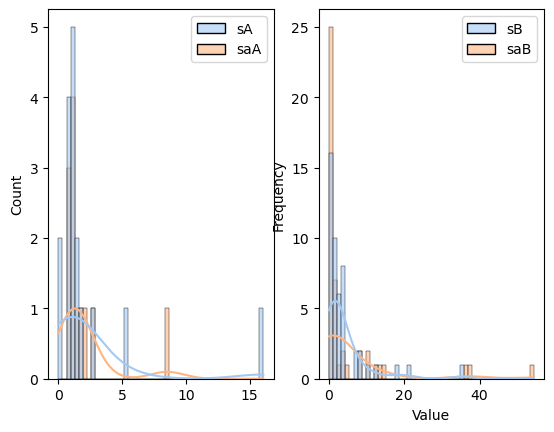

P08 & 0.633 & 0.902 \\ \hline 


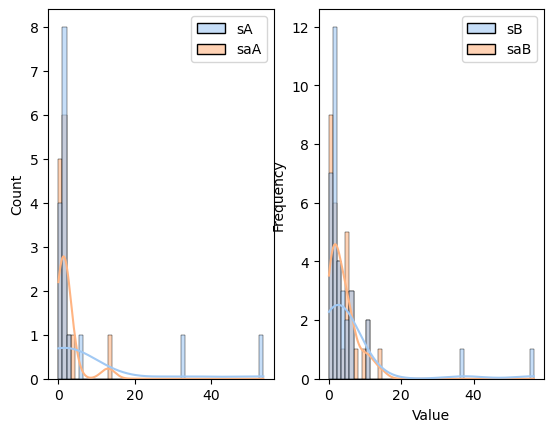

P09 & 0.003 & 0.412 \\ \hline 


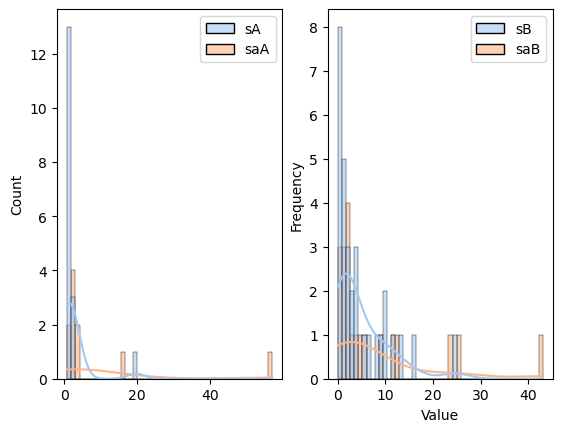

P10 & 0.229 & 0.245 \\ \hline 


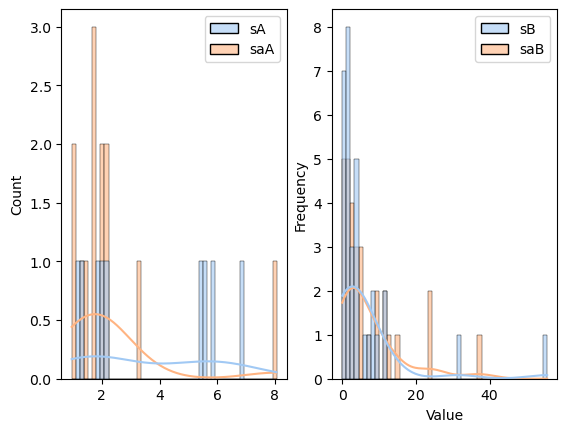

P16 & 0.972 & 0.135 \\ \hline 


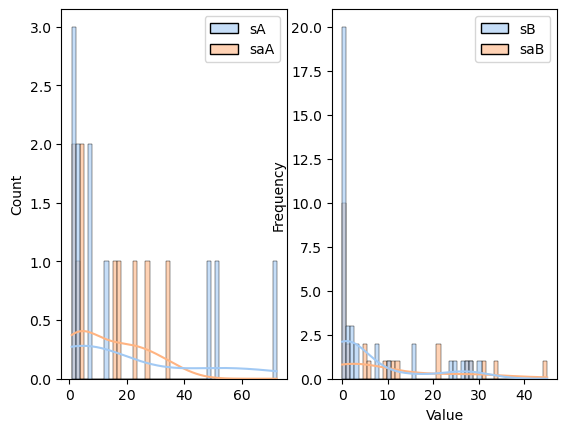

P17 & 0.501 & 0.168 \\ \hline 


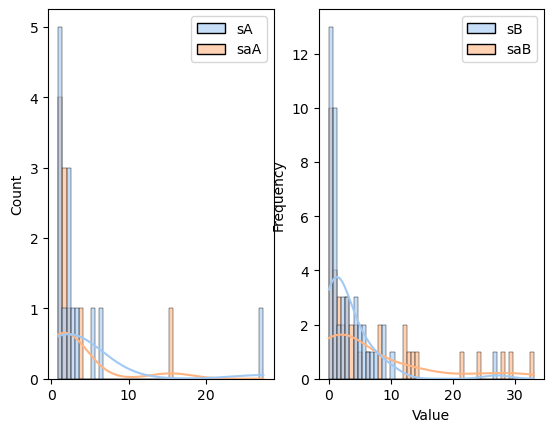

P18 & 0.281 & 0.981 \\ \hline 


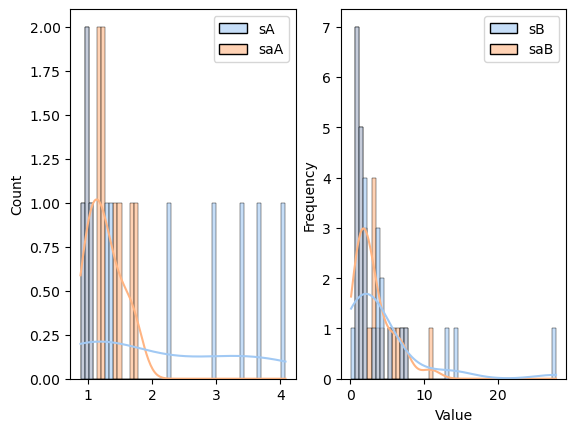

P23 & 0.189 & 0.778 \\ \hline 


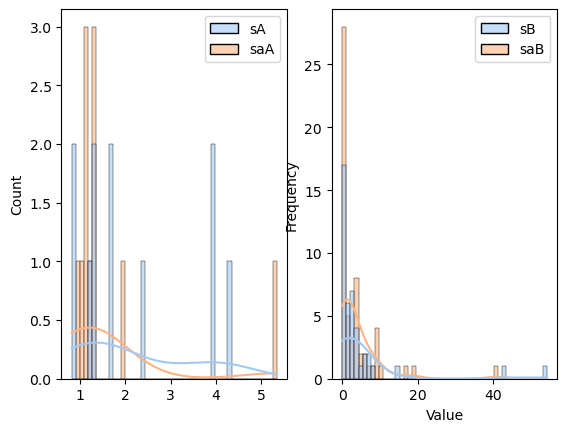

P24 & 0.384 & 0.009 \\ \hline 


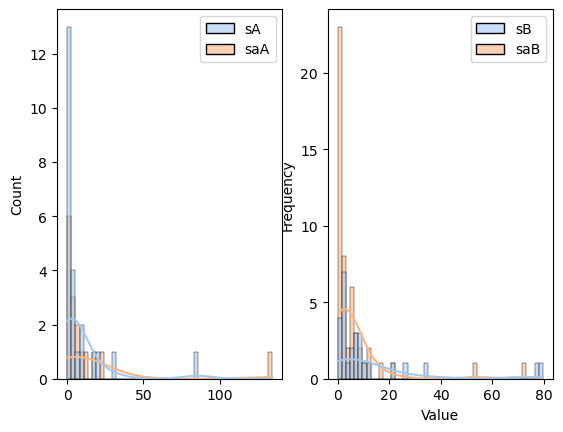

P25 & 0.165 & 0.759 \\ \hline 


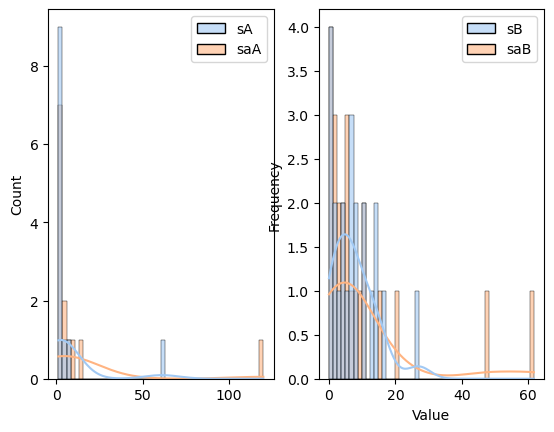

In [69]:
# group by participant
fp = compute_failure_proportion_intervals()
fp['score'] = fp['t2'] - fp['t1']

def plot_hist(data, ax):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    sns.histplot(data=_df, ax=ax, kde=True, alpha=0.6, palette='pastel', bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

for p, df in fp.groupby('participant'):
    
    sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
    sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

    mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
    mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
    #print(f"{p} A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
    #print(f"{p} B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")
    print(f"{p} & {mannwhitneyuA.pvalue:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes = axes.ravel()
    plot_hist({'sA': sA['score'], 'saA': saA['score']}, axes[0])
    plot_hist({'sB': sB['score'], 'saB': saB['score']}, axes[1])
    plt.show()





fuel & 0.835 & 0.492 \\ \hline 


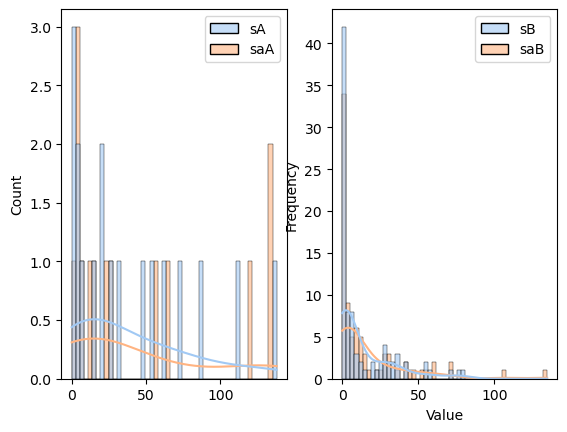

system & 0.289 & 0.477 \\ \hline 


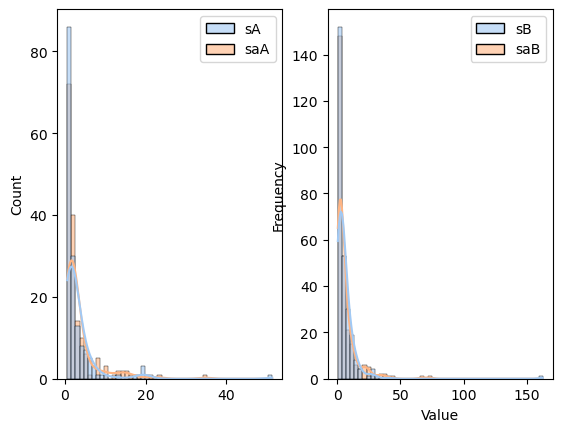

tracking & 0.860 & 0.240 \\ \hline 


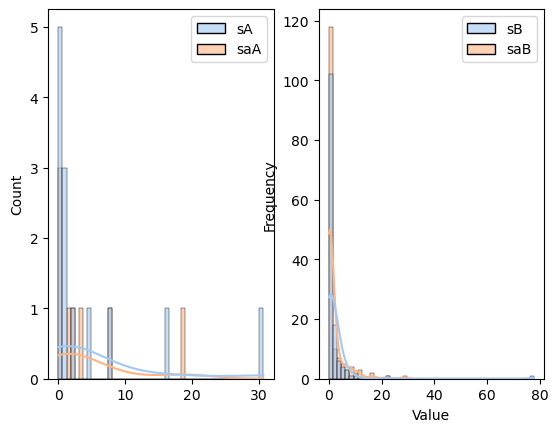

In [75]:
# group by participant
fp = compute_failure_proportion_intervals()
fp['score'] = fp['t2'] - fp['t1']

def plot_hist(data, ax):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    sns.histplot(data=_df, ax=ax, kde=True, alpha=0.6, palette='pastel', bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

for t, df in fp.groupby('task'):
    
    sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
    sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

    mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
    mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
    #print(f"{p} A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
    #print(f"{p} B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")
    print(f"{t} & {mannwhitneyuA.pvalue:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes = axes.ravel()
    plot_hist({'sA': sA['score'], 'saA': saA['score']}, axes[0])
    plot_hist({'sB': sB['score'], 'saB': saB['score']}, axes[1])
    plt.show()





A: 16701.000 & 0.278 \\ \hline 
B: 128781.000 & 0.620 \\ \hline 


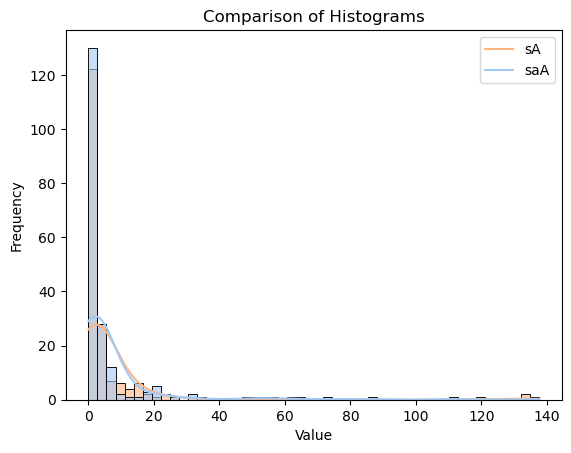

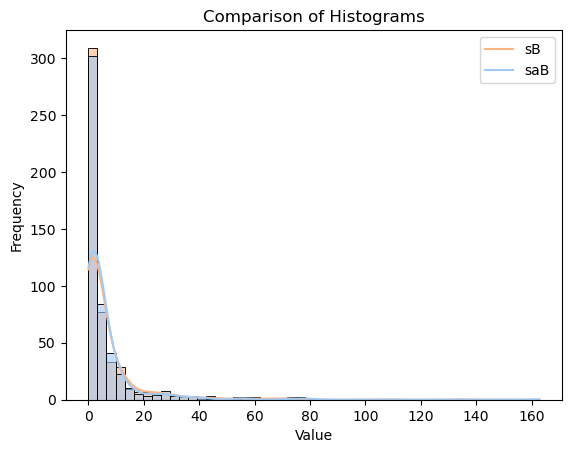

In [73]:
fp = compute_failure_proportion_intervals()
fp['score'] = fp['t2'] - fp['t1']
df = fp

sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
print(f"A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
print(f"B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

def plot_hist(data):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    sns.histplot(data=_df, kde=True, alpha=0.6, palette='pastel', bins=50)
    plt.legend(data.keys())
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Comparison of Histograms')
    plt.show()
    
plot_hist({'sA': sA['score'], 'saA': saA['score']})
plot_hist({'sB': sB['score'], 'saB': saB['score']})
